In [14]:
%pylab inline

import sncosmo

from glob import glob
import copy


import pymc3 as pm
import theano
import theano.tensor as T
from theano.compile.ops import as_op
import scipy.optimize as optimize
from astropy import cosmology

from astropy.table import Column

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# Load SDSS filter as used in JLA
for band in list('ugriz'):
    f = open('snfit_data/Instruments/SDSS/%s-no-atmosphere.dat'%band)
    band_data = [line.split() for line in f]
    f.close()
    
    wl = np.array([float(a[0]) for a in band_data])
    tr = np.array([float(a[1]) for a in band_data])
    
    bandpass = sncosmo.Bandpass(wl, tr)
    sncosmo.registry.register(bandpass, 'jla_sdss%s'%band)

## Define the model

In [3]:
# Fit the lc
# First need to add MW dust correction to model
dust = sncosmo.CCM89Dust()
salt = sncosmo.Model(source='salt2',
                      effects=[dust],
                      effect_names=['mw'],
                      effect_frames=['obs'])

## Load the data

In [4]:
sdssLCfiles=glob("jla_light_curves/lc-SDSS*")#[:30]

In [5]:
data=map(lambda f: sncosmo.io.read_lc(f, format='salt2') ,sdssLCfiles)
tStarts = map(lambda x: x['Date'][0],data )

nData = len(data)

In [6]:
def preProcessData(data,model):
    new_column = Column(data=['jla_sdss%s'%a[-1] for a in data['Filter']], name='Filter', dtype='S20')
    data.remove_column('Filter')
    data.add_column(new_column)
    datum = copy.deepcopy(data)
    #datum['Filter'] = ['sdss%s'%a[-1] for a in datum['Filter']]
    datum['MagSys'] = ['ab' for a in datum['MagSys']]
    datum['Date'] = datum['Date'] -datum['Date'][0]
    #datum = sncosmo.photdata.standardize_data(datum)
    #datum = sncosmo.photdata.normalize_data(datum)
    #datum = sncosmo.fitting.cut_bands(datum,salt)
    return datum










    

In [55]:
processedData = map(lambda d: preProcessData(d,salt),data)    


params = []
muB = []

errC=[]
errX1=[]

for lc in processedData:
    
    
    # redshift and MW E(B-V) were in file header 
    salt.set(z=lc.meta['Z_HELIO'], mwebv=lc.meta['MWEBV'])
    res, fitted_model = sncosmo.fit_lc(lc, salt, ['t0', 'x0', 'x1', 'c'])
    muB.append(  fitted_model.bandmag('bessellb', 'ab', fitted_model.parameters[1]))
    
    
    errC.append(res['errors']['c'])
    errX1.append(res['errors']['x1'])
    
    tmp = fitted_model.parameters[[0,1,2,3,4]].tolist()
    
    params.append(tmp)
    
    


params=array(params)
muB=array(muB)
allC = params[:,4]
allX1 = params[:,3]
allX0 = params[:,2]
allZ = params[:,0]


errC=array(errC)
errX1=array(errX1)

In [53]:
res['errors']['x1']

0.2808220016077545

In [ ]:
# plot(allZ,muB,'.')
spefCosmo = cosmology.FlatLambdaCDM(H0=72., Om0=0.3)
plot(zGrid,spefCosmo.distmod(zGrid).value-19,'r')

## Utility OPS for theano

In [38]:
@as_op(itypes=[T.dscalar],otypes=[T.dvector])
def get_distMod(omegaM):
    cosmo = cosmology.FlatLambdaCDM(H0=72., Om0=omegaM)
    return cosmo.distmod(allZ).value
get_distMod.grad=lambda x,y:  [x[0]]

In [57]:
lcModel= pm.Model()


with lcModel:
    
    # Light Curve Priors
    #t0 = pm.Uniform('t0',lower=0.,upper=100.,    shape=nData)
    #x0 = pm.Uniform('x0',lower=1E-7, upper=1E-1, shape=nData)
    #x1 = pm.Normal('x1',mu=0., sd=2.,            shape=nData)
    #c  = pm.Normal('c',mu=0., sd=1.,             shape=nData)
    
    # Cosmology Priors
    #H0 = theano.shared#pm.Normal("H0",mu=72.,sd=8.)
    OmegaM = pm.Uniform("OmegaM",lower=0,upper=1.)
    M = pm.Uniform("M",lower=-21.3,upper=-17.)
    alpha = pm.Uniform("alpha",lower=-2.,upper=2.)
    beta = pm.Uniform("beta",lower=-4.,upper=4.)
    sysScat = pm.HalfCauchy("sysScat",beta=2.5)
   
    
   
    
                      
    xm=pm.Uniform('xm',lower=-10,upper=10)
    cm=pm.Uniform('cm',lower=-3,upper=3)
    Rx=pm.Uniform('Rx',lower=-5,upper=2)
    Rc=pm.Uniform('Rc',lower=-5,upper=2)
    
   


    x_true  = pm.Normal('x_true',mu=xm, sd=10**Rx,shape=len(allC))
    c_true  = pm.Normal('c_true',mu=cm, sd=10**Rc,shape=len(allC))
    
    
    
    
   
    
    #mB = pm.Deterministic("mB",muB)
    
    dm = get_distMod(OmegaM)
    
    csm = M + dm - alpha*x_true + beta*c_true
    
    obsc=pm.Normal("obsc",mu=c_true,sd=errC, observed=allC)
    obsx=pm.Normal("obsx",mu=x_true,sd=errX1, observed=allX1)
    #print muB
    csm_points = pm.Normal("csm_points",mu=csm,sd=sysScat,observed=muB)
    
    
    
    
    

Applied interval-transform to OmegaM and added transformed OmegaM_interval to model.
Applied interval-transform to M and added transformed M_interval to model.
Applied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to beta and added transformed beta_interval to model.
Applied log-transform to sysScat and added transformed sysScat_log to model.
Applied interval-transform to xm and added transformed xm_interval to model.
Applied interval-transform to cm and added transformed cm_interval to model.
Applied interval-transform to Rx and added transformed Rx_interval to model.
Applied interval-transform to Rc and added transformed Rc_interval to model.


In [58]:
with lcModel:
    start=pm.find_MAP(fmin=optimize.fmin_powell)

In [13]:
start

NameError: name 'start' is not defined

In [60]:
with lcModel:
    
    step=pm.Metropolis()
    trace=pm.sample(20000,step=step,start=start,progressbar=True)

 [-----------------100%-----------------] 20000 of 20000 complete in 657.5 sec

In [12]:
pm.traceplot(trace[2500:],varnames=["OmegaM","M"])

TypeError: 'function' object has no attribute '__getitem__'

In [ ]:
trace.chains?

In [ ]:
zGrid = linspace(0,.5,100)

In [ ]:
trace[10]

In [ ]:
for tr in trace[2500::50]:
    
    spefCosmo = cosmology.FlatLambdaCDM(H0=72., Om0=tr['OmegaM'])
    plot(zGrid,spefCosmo.distmod(zGrid).value+tr["M"],'r',alpha=0.05)
    plot(allZ,muB-allC*tr['beta']+tr['alpha']*allX1,'b.',alpha=0.05)

    spefCosmo = cosmology.FlatLambdaCDM(H0=72., Om0=.3)
    plot(zGrid,spefCosmo.distmod(zGrid).value+tr["M"],'k',alpha=0.05)
    
    spefCosmo = cosmology.FlatLambdaCDM(H0=72., Om0=1)
    plot(zGrid,spefCosmo.distmod(zGrid).value+tr["M"],'k',alpha=0.05)


In [6]:
from astropy.table import Table
jlaSet = Table.read("jla_lcparams.txt",format='ascii')

tmp =[]
for x in jlaSet['name']:
    if "SDSS" in x:
        tmp.append(True)
    else: tmp.append(False)
        
sdssCond=array(tmp)


#jlaSet = jlaSet[sdssCond]


In [65]:
jlaSet

name,zcmb,zhel,dz,mb,dmb,x1,dx1,color,dcolor,3rdvar,d3rdvar,tmax,dtmax,cov_m_s,cov_m_c,cov_s_c,set,ra,dec,biascor
str9,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
03D1au,0.503084,0.5043,0,23.001698,0.088031,1.273191,0.150058,-0.012353,0.030011,9.517,0.1105,52909.74522,0.214332,0.00079,0.00044,-3e-05,1,36.04321,-4.037469,0.001697
03D1aw,0.580724,0.582,0,23.573937,0.090132,0.974346,0.273823,-0.025076,0.036691,9.169,0.088,52902.898002,0.352732,0.002823,0.000415,0.001574,1,36.061634,-4.517158,0.000843
03D1ax,0.494795,0.496,0,22.960139,0.08811,-0.728837,0.102069,-0.099683,0.030305,11.58,0.1125,52915.92367,0.111634,0.000542,0.000475,-2.4e-05,1,36.097287,-4.720774,0.001692
03D1bp,0.345928,0.347,0,22.398137,0.087263,-1.15511,0.112834,-0.040581,0.026679,10.821,0.1235,52920.249015,0.102828,0.001114,0.000616,0.000295,1,36.657235,-4.838779,-0.00027
03D1co,0.677662,0.679,0,24.078115,0.098356,0.61882,0.404295,-0.03938,0.067403,8.647,0.284,52954.458342,0.454715,0.011857,0.00078,0.005898,1,36.567748,-4.93505,-0.002855
03D1dt,0.610712,0.612,0,23.285241,0.092877,-1.161563,1.641345,-0.094943,0.049652,9.715,0.092,52962.253197,0.976562,0.029671,0.000947,0.044357,1,36.629968,-4.052341,2.6e-05
03D1ew,0.866494,0.868,0,24.353678,0.106037,0.376409,0.348004,-0.063269,0.067817,8.53,0.805,52991.741625,0.665126,0.003181,-0.001601,0.004093,1,36.058795,-4.665852,-0.017996
03D1fc,0.330932,0.332,0,21.861412,0.086437,0.650394,0.118542,-0.017577,0.023794,10.391,0.036,53002.763813,0.104433,0.001006,0.000527,0.00054,1,36.431648,-4.144059,-0.000526
03D1fq,0.798566,0.8,0,24.510389,0.101777,-1.056666,0.406837,-0.055975,0.064955,10.651,0.127,52999.213046,0.655817,0.005897,-0.001115,0.003551,1,36.731935,-4.302217,-0.011577


In [9]:
@as_op(itypes=[T.dscalar],otypes=[T.dvector])
def get_distMod(omegaM):
    cosmo = cosmology.FlatLambdaCDM(H0=72., Om0=omegaM)
    return cosmo.distmod(jlaSet['zcmb']).value
get_distMod.grad=lambda x,y:  [x[0]]


lcModel2= pm.Model()


with lcModel2:
    
    # Light Curve Priors
    #t0 = pm.Uniform('t0',lower=0.,upper=100.,    shape=nData)
    #x0 = pm.Uniform('x0',lower=1E-7, upper=1E-1, shape=nData)
    #x1 = pm.Normal('x1',mu=0., sd=2.,            shape=nData)
    
    
    # Cosmology Priors
    #H0 = theano.shared#pm.Normal("H0",mu=72.,sd=8.)
    OmegaM = pm.Uniform("OmegaM",lower=0,upper=1.)
    M = pm.Uniform("M",lower=-20.3,upper=-18.3)
    alpha = pm.Uniform("alpha",lower=-2.,upper=2.)
    beta = pm.Uniform("beta",lower=-4.,upper=4.)
    sysScat =  pm.Uniform('sysScat',lower=-3,upper=0)   #pm.HalfCauchy("sysScat",beta=2.5)
   
    xm=pm.Uniform('xm',lower=-10,upper=10)
    cm=pm.Uniform('cm',lower=-3,upper=3)
    Rx=pm.Uniform('Rx',lower=-5,upper=2)
    Rc=pm.Uniform('Rc',lower=-5,upper=2)
    
   


    x_true  = pm.Normal('x_true',mu=xm, sd=10**Rx,shape=len(jlaSet['color']))
    c_true  = pm.Normal('c_true',mu=cm, sd=10**Rc,shape=len(jlaSet['color']))
    
    dm = get_distMod(OmegaM)
    
    mb = pm.Normal("mb",mu=M + dm - alpha*x_true + beta*c_true,sd=10**sysScat,shape=len(jlaSet['color']))
    
    obsc=pm.Normal("obsc",mu=c_true,sd=array(jlaSet['dcolor']), observed=jlaSet['color'])
    obsx=pm.Normal("obsx",mu=x_true,sd=array(jlaSet['dx1']), observed=jlaSet['x1'])
    
    obsm = pm.Normal("obsm",mu=mb,sd=array(jlaSet['dmb']),observed=jlaSet['mb'])
    
    
   
    
    
    
    
    
     
    
    
    #print muB
    
    

Applied interval-transform to OmegaM and added transformed OmegaM_interval to model.
Applied interval-transform to M and added transformed M_interval to model.
Applied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to beta and added transformed beta_interval to model.
Applied interval-transform to sysScat and added transformed sysScat_interval to model.
Applied interval-transform to xm and added transformed xm_interval to model.
Applied interval-transform to cm and added transformed cm_interval to model.
Applied interval-transform to Rx and added transformed Rx_interval to model.
Applied interval-transform to Rc and added transformed Rc_interval to model.


In [10]:
with lcModel2:
    start2=pm.find_MAP(fmin=optimize.fmin_powell)

In [11]:
start2

{'M_interval': array(0.42531074412309056),
 'OmegaM_interval': array(-0.779097771399518),
 'Rc_interval': array(0.29341671401795827),
 'Rx_interval': array(0.881335252927799),
 'alpha_interval': array(0.036520028656243445),
 'beta_interval': array(0.7694206137447511),
 'c_true': array([ -2.09139536e-02,   1.81567948e-03,  -8.29939302e-02,
         -1.13121459e-02,   1.26579701e-01,  -1.45600701e-01,
         -6.02392652e-02,  -2.91440995e-02,   8.29990868e-02,
         -7.40029664e-02,  -4.35801416e-02,   1.00825933e-01,
          1.98636386e-01,  -6.86594548e-02,  -1.00382460e-01,
          4.53113997e-02,   2.84649832e-01,  -1.02631900e-01,
          1.45244801e-03,   1.69470828e-02,   6.53182624e-02,
         -8.53631567e-02,  -1.14202315e-01,  -1.11524767e-01,
          8.17401163e-03,  -4.62875545e-02,  -7.44567414e-03,
         -2.50880402e-02,   3.97649843e-03,  -7.00937406e-02,
          1.54861831e-03,  -8.68454548e-02,   1.06709703e-01,
         -5.16779756e-02,  -1.47384968e

In [82]:
with lcModel2:
    
    step2=pm.Metropolis()
    trace2=pm.sample(10000,step=step2,start=start2,progressbar=True,)

 [-----------------100%-----------------] 10000 of 10000 complete in 486.5 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15fc7d7d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x16708e410>]], dtype=object)

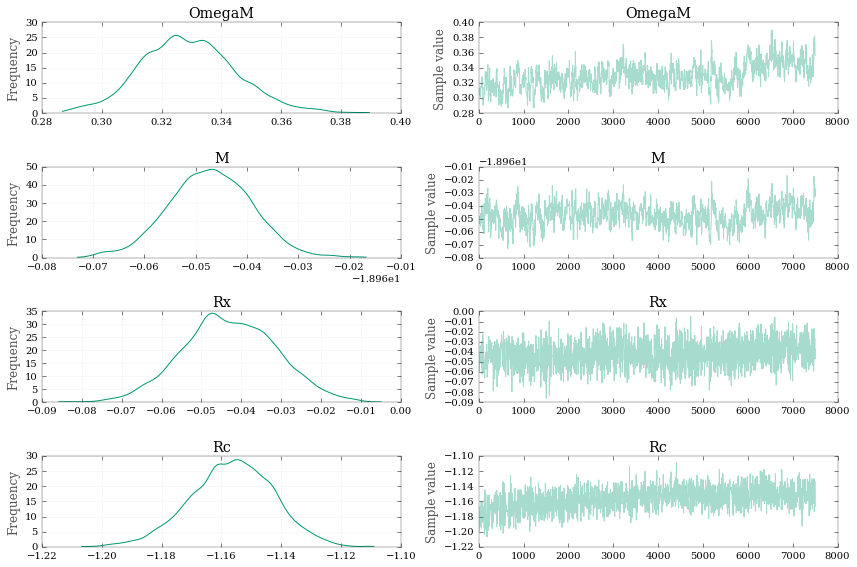

In [83]:
pm.traceplot(trace2[2500:],varnames=["OmegaM","M","Rx","Rc"])

In [73]:
pm.summary(trace2[5000:])


OmegaM_interval:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.399           0.000            0.000            [-0.399, -0.399]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.399         -0.399         -0.399         -0.399         -0.399


M_interval:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.715            0.000            0.000            [0.715, 0.715]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.715          0.715          0.715          0.715          0.715


alpha_interval:

  Mean             SD               MC Error         95% HPD interval


In [33]:
zGrid = linspace(0,1.5,100)
for tr in trace2[7500::50]:
    
    spefCosmo = cosmology.FlatLambdaCDM(H0=72., Om0=tr['OmegaM'])
    plot(zGrid,spefCosmo.distmod(zGrid).value+tr["M"],'r',alpha=0.05)
    #plot(jlaSet['zcmb'],jlaSet['mb']-jlaSet['color']*tr['beta']+tr['alpha']*jlaSet['x1'],'b.',alpha=0.01)

   


NameError: name 'trace2' is not defined

In [ ]:
pm.summary(trace)

In [ ]:
plot(jlaSet['zcmb'],jlaSet['mb'],'.')
plot(allZ,muB,'.')
legend(['jla','sncosmo'],loc='lower right')

ylabel(r'$m_B$')
xlabel('zcmb')
savefig('/Users/jburgess/Desktop/mb.pdf',bbox_inches='tight')

In [ ]:
plot(jlaSet['zcmb'],(muB-jlaSet['mb'])/jlaSet['mb'],'.')
#plot(allZ,muB,'.')


ylabel(r'Rel. $\Delta m_B$')
xlabel('zcmb')
ylim(bottom=-0.02)
savefig('/Users/jburgess/Desktop/mb_diff.pdf',bbox_inches='tight')

In [13]:
jlaSet

name,zcmb,zhel,dz,mb,dmb,x1,dx1,color,dcolor,3rdvar,d3rdvar,tmax,dtmax,cov_m_s,cov_m_c,cov_s_c,set,ra,dec,biascor
str9,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
SDSS10028,0.064229,0.06533,0,18.347945,0.112975,-1.201799,0.18701,0.01006,0.025413,10.531,0.0435,53693.660337,0.177004,0.0013,0.000548,0.000597,2,17.741856,0.276253,-0.000664
SDSS1032,0.12903,0.12976,0,20.336945,0.115931,-2.528617,0.199976,0.050506,0.036779,10.456,0.022,53626.521013,0.198807,0.002692,0.001133,0.000838,2,46.795696,1.119552,-0.00124
SDSS10434,0.10289,0.10418,0,19.156988,0.114221,-0.005434,0.280897,-0.08741,0.026896,10.955,0.1285,53696.470787,0.217773,0.005774,0.000781,0.003225,2,-30.04409,-1.193712,-0.001137
SDSS10805,0.04413,0.04542,0,17.531728,0.11486,-0.952693,0.402381,0.056678,0.024892,9.998,0.206,53698.687684,0.125472,0.006306,0.000594,0.003643,2,-15.072472,-0.01373,-0.000235
SDSS11067,0.11304,0.114,0,19.114133,0.112246,1.733698,0.520618,-0.072351,0.026351,9.42,0.0865,53702.777528,0.402505,0.005632,0.000568,0.006371,2,33.518394,-0.239178,-0.001195
SDSS1112,0.25611,0.25764,0,21.537919,0.12482,-0.623265,0.675408,-0.026817,0.051918,11.13,0.2175,53630.086004,0.67861,0.024142,0.001549,0.005258,2,-20.982361,-0.375189,-0.00045
SDSS11206,0.38026,0.3819,0,22.200281,0.138121,-1.510288,0.87276,-0.205532,0.085154,10.689,0.1605,53697.222252,1.648688,0.032602,0.001346,0.032911,2,3.289774,1.145541,-0.000372
SDSS11300,0.14547,0.1468,0,20.28342,0.113737,-1.607355,0.675537,0.075146,0.032765,9.291,0.1085,53699.544122,0.319765,0.008831,0.000895,0.010478,2,6.750494,-0.586624,-0.001234
SDSS1241,0.08889,0.0902,0,19.115082,0.11251,-0.547524,0.078724,0.048945,0.022754,10.171,0.132,53635.370749,0.078459,0.000578,0.000522,5.1e-05,2,-22.327475,-0.776589,-0.001014


In [12]:
jlaSet['name'][sdssCond]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 368 but corresponding boolean dimension is 740
  if __name__ == '__main__':


IndexError: index 368 is out of bounds for axis 1 with size 368

In [14]:
rawNames = map(lambda x: x.split('-')[-1].split('.')[0],sdssLCfiles)



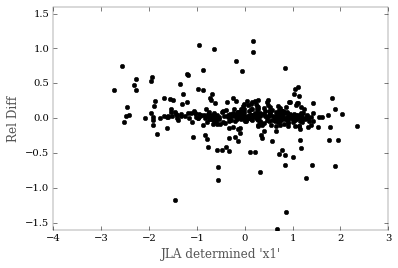

In [31]:
for n,p in zip(rawNames,allX1):
    
     scatter(array(jlaSet['x1'])[jlaSet['name']==n][0],(p-array(jlaSet['x1'])[jlaSet['name']==n][0]),color='k')
    
ylim(bottom=-1.6,top=1.6) 

ylabel("Rel Diff")

xlabel("JLA determined 'x1'")


#savefig("/Users/jburgess/Desktop/x1.pdf",bbox_inches="tight")

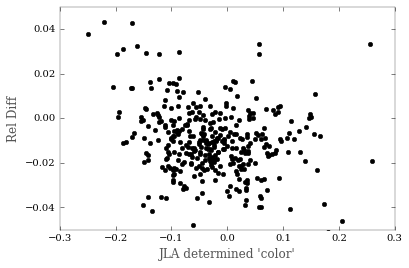

In [26]:

for n,p in zip(rawNames,allC):
    
     scatter(array(jlaSet['color'])[jlaSet['name']==n][0],(p-array(jlaSet['color'])[jlaSet['name']==n][0]),color='k')
        
        
ylim(bottom=-.05,top=.05)  

ylabel("Rel Diff")

xlabel("JLA determined 'color'")

#savefig("/Users/jburgess/Desktop/color.pdf",bbox_inches="tight")



In [ ]:
for n,p in zip(rawNames,muB):
    
     plot(array(jlaSet['mb'])[jlaSet['name']==n][0],(p-array(jlaSet['mb'])[jlaSet['name']==n][0])/array(jlaSet['mb'])[jlaSet['name']==n][0],'k.')

In [ ]:
muB